In [1]:
from IPython.display import display
import random

import pandas as pd
import numpy as np
import folium

from packages.custom_kmeans import KMeans

random.seed(42)

In [2]:
df_raw = pd.read_csv('superstore-dataset-processed.csv')
df_raw.dropna(inplace=True)
display(df_raw.head(3))
print(df_raw.describe())

,Unnamed: 0,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,...,product_id,category,sub-category,product_name,sales,quantity,discount,profit,latitude,longitude
0,0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,32.182598,-95.789318
1,1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,32.182598,-95.789318
2,2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714,34.053691,-118.242766


        Unnamed: 0       row_id   postal_code         sales     quantity  \
count  9994.000000  9994.000000   9994.000000   9994.000000  9994.000000   
mean   4996.500000  4997.500000  55190.379428    229.858001     3.789574   
std    2885.163629  2885.163629  32063.693350    623.245101     2.225110   
min       0.000000     1.000000   1040.000000      0.444000     1.000000   
25%    2498.250000  2499.250000  23223.000000     17.280000     2.000000   
50%    4996.500000  4997.500000  56430.500000     54.490000     3.000000   
75%    7494.750000  7495.750000  90008.000000    209.940000     5.000000   
max    9993.000000  9994.000000  99301.000000  22638.480000    14.000000   

          discount       profit     latitude    longitude  
count  9994.000000  9994.000000  9994.000000  9994.000000  
mean      0.156203    28.656896    37.578511   -94.900332  
std       0.206452   234.260108     4.922599    17.792961  
min       0.000000 -6599.978000    25.471895  -123.815722  
25%       0.000

## Выбираем числовые признаки и суммируем по широте/долготе

In [3]:
df_features = df_raw[['sales', 'quantity', 'profit', 'latitude', 'longitude']].groupby(by=['latitude', 'longitude']).sum()
df_features.reset_index(drop=False, inplace=True)
display(df_features.sort_values(by=['profit'], ascending=False).head(3))
print(df_features.shape[0])

,latitude,longitude,sales,quantity,profit
359,40.712728,-74.006015,256368.161,3417,62036.9837
169,34.053691,-118.242766,175851.341,2879,30440.7579
523,47.603832,-122.330062,119540.742,1590,29156.0967


531


In [4]:
print(df_features.loc[
            (df_features['sales'] > 0) & (df_features['quantity'] > 0) & (df_features['profit']), 
            ['sales', 'quantity', 'profit']
        ]
)
df_features['location_type'] = 'demand'

         sales  quantity     profit
0     132.5520         5    22.3291
1      64.2480         6    22.3578
2    8673.0745       215 -1150.3704
3    2338.9490        76  -179.2275
4      22.1280         6     3.0798
..         ...       ...        ...
526  1098.2570        52  -153.7178
527  2523.6920        42   634.2478
528  5665.7340        84  1361.4787
529   102.1800        15     3.3150
530  3790.2400        24   610.5908

[531 rows x 3 columns]


## Отрисуем на карте пункты доставки заказов с учетом профита (точка с большим радиусов -> больше профит)

In [5]:
VOLUME_MAP_SCALE = 2000
# Словарь цветов для элементов карты
color_options = {
    'demand': 'red',
    'supply': 'yellow',
    'flow': 'black',
    'cog': 'blue',
    'candidate': 'black',
    'other': 'gray',
    'cur_supplier': 'green'
}

# Инициализация карты
map = folium.Map(
    location=df_features[['latitude', 'longitude']].mean(),
    fit_bounds=[
        [
            df_features['latitude'].min(),
            df_features['longitude'].min()
        ], 
        [
            df_features['latitude'].max(),
            df_features['longitude'].max()
        ]
    ]
)

# Добавление точек на карту с учетом их относительного объема
for _, row in df_features.iterrows():
    # if str(row['location_type']).lower() in (['demand', 'supply']):
        # folium.PolyLine([(row['latitude'],
        #                   row['longitude']),
        #                  (row['latitude_cog'],
        #                   row['longitude_cog'])],
        #                 color=color_options['flow'],
        #                 weight=(row['profit']/5000),
        #                 opacity=0.1).add_to(map)
                        
    folium.CircleMarker(
        location = [
            row['latitude'], 
            row['longitude']
        ],
        radius=(row['profit']/VOLUME_MAP_SCALE), # **0.5
        color=color_options.get(str(row['location_type']).lower(), 'gray'),
        # tooltip=str(row['branch_name'])+' '+str(row['profit'])).add_to(map)
        tooltip=str(row['profit'])).add_to(map)

        
# Масштаб отображения карты основывается на объемах точек
map.fit_bounds(df_features[['latitude', 'longitude']].values.tolist())
# Отображение карты
map


## Определим оптимальное количество кластеров с помощью метода "Локтя"

In [6]:
kmeans_kwargs = {
    "init": "random",
    # "n_init": 10,
    # "random_state": 1,
}
range_n_clusters = [i for i in range(2, divmod(df_features.shape[0], 2)[0])]
# print(range_n_clusters)
sum_of_squared_distances = []
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(
        df_features.loc[
            df_features['profit'] > 0,
                [
                    'latitude',
                    'longitude'
                ]
            ], 
        sample_weight = df_features.loc[
            df_features['profit'] > 0,
            'profit'
        ]
    )
    
    sum_of_squared_distances.append(kmeans.inertia_)

/Users/alexey/Documents/Repositories/GitHub/search_centriods/packages/custom_kmeans.py:598: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/alexey/Documents/Repositories/GitHub/search_centriods/packages/custom_kmeans.py:598: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/alexey/Documents/Repositories/GitHub/search_centriods/packages/custom_kmeans.py:598: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/alexey/Documents/Repositories/GitHub/search_centriods/packages/custom_kmeans.py:598: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

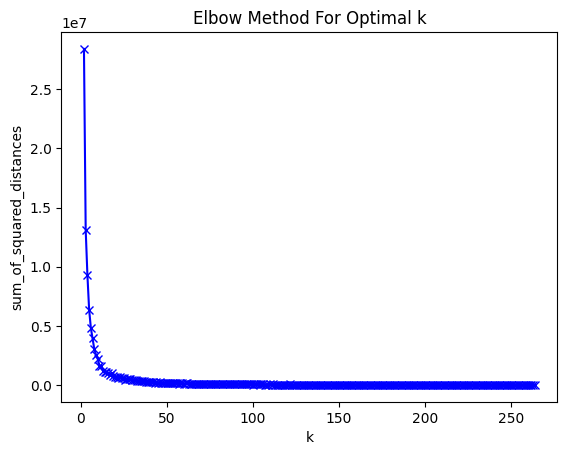

In [7]:
import matplotlib.pyplot as plt 

plt.plot(range_n_clusters, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
from kneed import KneeLocator
kl = KneeLocator(range_n_clusters, sum_of_squared_distances, curve="convex", direction="decreasing")
best_num_clusters = kl.elbow
print(f"{best_num_clusters = }")

best_num_clusters = 13


## Кластеризуем с учетом полученного оптимального числа кластеров с помощью метода "Локтя"

In [9]:

kmeans = KMeans(
    n_clusters = best_num_clusters,
    **kmeans_kwargs
    # random_state = 0
)

kmeans.fit(
    df_features.loc[
        df_features['profit'] > 0,
            [
                'latitude',
                'longitude'
            ]
        ], 
    sample_weight = df_features.loc[
        df_features['profit'] > 0, 
        'profit'
    ]
)


/Users/alexey/Documents/Repositories/GitHub/search_centriods/packages/custom_kmeans.py:598: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Подготовим данные для отображения на карте

In [10]:
# Получим центры масс, рассчитанные в KMeans
cogs = kmeans.cluster_centers_
cogs = pd.DataFrame(
    cogs,
    columns = [
        'latitude',
        'longitude'
    ]
)
# Получим сумму объемов каждого центроида
df_features['cluster'] = kmeans.predict(df_features[['latitude', 'longitude']])
cogs = cogs.join(df_features.groupby('cluster')['profit'].sum())
# Джонм полученных координат центроидов по кластеру к df_features
df_features = df_features.join(cogs, on='cluster', rsuffix='_cog')

df_features_clusters = df_features[['cluster', 'latitude_cog', 'longitude_cog']].drop_duplicates().sort_values(by=['cluster']).reset_index(drop=True)

## Отрисуем на карте центроиды, расчитанные с учетом расстояния по автодорогам с весами - прибылью
Чем больше прибыль, тем толще линия-связь центра и города получателя

In [11]:
# Добавление на карту линий в центры масс
for _, row in df_features.iterrows():
    # Flow lines
    if str(row['location_type']).lower() in (['demand', 'supply']):
        folium.PolyLine([(row['latitude'],
                          row['longitude']),
                         (row['latitude_cog'],
                          row['longitude_cog'])],
                        color=color_options['flow'],
                        weight=(row['profit']/VOLUME_MAP_SCALE),
                        opacity=0.5).add_to(map)
                        
# Добавление на карту центроидов
for _, row in cogs.iterrows():
    # Города новых центров тяжести
    folium.CircleMarker(location=[row['latitude'],
                                  row['longitude']],
                        radius=(row['profit']/VOLUME_MAP_SCALE),
                        color=color_options['cog'],
                        tooltip=row['profit']).add_to(map)
map